<a href="https://colab.research.google.com/github/likhitha-kadiyala/Sai-Likhitha_INFO5731_Spring2021/blob/main/In_class_exercise/In_class_exercise_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 3/16/2021)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

In [1]:
#installing nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
#installing java
import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java()

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [3]:
#upgrading gensim
!pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 51.6MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [4]:
import spacy.cli
spacy.cli.download("en")


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [7]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [6]:
pip install pyLDAvis

     |████████████████████████████████| 1.7MB 5.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=5ec6ac466781510ba5364425a518239055a35b2010f6eae27b1e4ebbab274f92
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


In [8]:
#importing stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [9]:
from google.colab import files
loaded_files = files.upload()

Saving 100 titles.csv to 100 titles.csv


In [10]:
articles_titles = pd.read_csv('100 titles.csv', encoding = "ISO-8859-1")
articles_titles.head(10)

,Column1
0,Techniques and applications for sentiment anal...
1,Sentiment analysis and subjectivity.
2,Sentiment analysis: A combined approach
3,Sentiment analysis algorithms and applications...
4,Using appraisal groups for sentiment analysis
5,Sentiment analysis of twitter data
6,A survey on sentiment analysis challenges
7,Comparing and combining sentiment analysis met...
8,Opinion mining and sentiment analysis
9,Joint sentiment/topic model for sentiment anal...


In [11]:
data = articles_titles['Column1'].tolist()

In [12]:
words = []
for value in data:
  words.append(gensim.utils.simple_preprocess(str(value), deacc=True))

In [15]:
#building bigrams and tri grams
bigram = gensim.models.Phrases(words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
#removing stopwords
stopword_removal = [[value for value in simple_preprocess(str(doc)) if value not in stop_words] for doc in words]
bigrams = [bigram_mod[doc] for doc in stopword_removal]

In [18]:
#lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])
postags=['NOUN', 'ADJ', 'VERB', 'ADV']
after_lemmatization = []
for sentence in bigrams:
  doc = nlp(" ".join(sentence)) 
  after_lemmatization.append([token.lemma_ for token in doc if token.pos_ in postags])

In [19]:

id2word = corpora.Dictionary(after_lemmatization)
texts = after_lemmatization
corpus = [id2word.doc2bow(text) for text in after_lemmatization]
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [20]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('analysis', 1), ('sentiment', 1)]]

In [21]:
#Building LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
coherence_model_lda = CoherenceModel(model=lda_model, texts=after_lemmatization, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.375938979191769

Coherence Score:  0.5604417679210496


In [34]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-03-19 18:13:04--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  16.2MB/s    in 1.0s    

2021-03-19 18:13:05 (16.2 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [35]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)



In [49]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [53]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=after_lemmatization, start=2, limit=60, step=6)

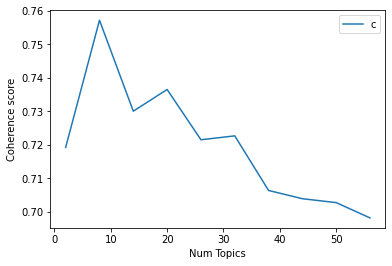

In [54]:
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [55]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.7192
Num Topics: 8  - Coherence Value: 0.7572
Num Topics: 14  - Coherence Value: 0.73
Num Topics: 20  - Coherence Value: 0.7365
Num Topics: 26  - Coherence Value: 0.7215
Num Topics: 32  - Coherence Value: 0.7227
Num Topics: 38  - Coherence Value: 0.7064
Num Topics: 44  - Coherence Value: 0.7039
Num Topics: 50  - Coherence Value: 0.7027
Num Topics: 56  - Coherence Value: 0.6982


In [56]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [57]:
#printing topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.127*"sentiment" + 0.066*"document" + 0.066*"chinese" + '
  '0.066*"subjectivity" + 0.004*"analysis" + 0.004*"mining" + 0.004*"opinion" '
  '+ 0.004*"education" + 0.004*"text" + 0.004*"medium"'),
 (1,
  '0.151*"analysis" + 0.150*"sentiment" + 0.073*"concept" + 0.073*"level" + '
  '0.051*"base" + 0.039*"use" + 0.038*"challenge" + 0.037*"approach" + '
  '0.020*"common" + 0.020*"sense"'),
 (2,
  '0.107*"analysis" + 0.107*"sentiment" + 0.055*"word" + 0.055*"vector" + '
  '0.055*"learn" + 0.055*"twitt" + 0.004*"mining" + 0.004*"survey" + '
  '0.004*"level" + 0.004*"text"'),
 (3,
  '0.095*"sentiment" + 0.085*"overview" + 0.049*"analysis" + 0.046*"current" + '
  '0.046*"envisage" + 0.046*"area" + 0.046*"state" + 0.046*"development" + '
  '0.046*"subjectivity" + 0.046*"learning"'),
 (4,
  '0.171*"sentiment" + 0.132*"analysis" + 0.040*"technique" + 0.030*"deep" + '
  '0.020*"survey" + 0.020*"use" + 0.020*"text" + 0.020*"topic" + '
  '0.020*"dependency" + 0.011*"review"'),
 (5,
  '0.093

In [58]:
#topic visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.052500 -0.032466       1        1  19.301199
9     -0.069839 -0.067687       2        1  15.910806
10    -0.163727  0.131763       3        1  13.371924
12    -0.136945 -0.045355       4        1  12.610080
1     -0.104587 -0.083270       5        1   9.612939
8     -0.047676  0.078637       6        1   7.198681
11     0.044622 -0.112127       7        1   5.405551
13     0.089656  0.032615       8        1   3.833128
3      0.062131  0.040011       9        1   3.250170
5      0.043104  0.022919      10        1   2.994185
2      0.017320  0.002189      11        1   2.329130
0      0.078485  0.021137      12        1   1.662867
7      0.070803  0.011072      13        1   1.446943
6      0.169154  0.000562      14        1   1.072395, topic_info=         Term       Freq      Total Category  logprob  loglift
1   sentiment  67.000000  67.000000  Default  30.0000  30.0000
15    opinion   7.000000   7.000000  Default  29.0000  29.0000
14     mining   7.000000   7.000000  Default  28.0000  28.0000
0    analysis  58.000000  58.000000  Default  27.0000  27.0000
35       base   5.000000   5.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
16      joint   0.025197   1.476908  Topic14  -5.2303   0.4643
17      model   0.025197   2.167960  Topic14  -5.2303   0.0804
18      topic   0.025197   2.309021  Topic14  -5.2303   0.0174
19    chinese   0.025197   1.870415  Topic14  -5.2303   0.2281
21        bad   0.025197   1.466784  Topic14  -5.2303   0.4712

[710 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
94        6  0.727747  affective
5         2  0.681765  algorithm
0         1  0.189113   analysis
0         2  0.171921   analysis
0         3  0.120344   analysis
...     ...       ...        ...
70        2  0.681764        web
131       1  0.677091     weight
28       10  0.567886       word
28       11  0.567886       word
129       1  0.677090       work

[226 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 11, 13, 2, 9, 12, 14, 4, 6, 3, 1, 8, 7])

**Summarization of LDA topics**
1. Sentiment Analysis of chinese documents
2. Common challenges in approching sentiment analysis
3. Survey on learning word vectors using sentiment analysis
4. An overview of current state of area of developments
5. Sentiment Analysis globally with local dependency. 
6. Overview of linguistics in sentiment Analysis.
7. Survey of opinion mining and challenges in Sentiment Analysis. 
8. Sentiment Analysis as a suitcase used for text mining. 
9. Methods of Combinations and Comparisions in Sentiment Analysis. 
10. Sentiment Analysis in Twitter using word vectors.
11. Survey on methods of approaching embedded systems using sentiment analysis. 
12. Sentiment Analysis of Social Media using a parsimonious rule. 
13. Sentiment Analysis in Twitter using semantics.
14. Opportunities in Medical settings using sentiment analysis. 

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [59]:
#importing LSA model
from gensim.models import LsiModel

In [60]:
lsamodel = LsiModel(corpus, 20, id2word)

In [62]:
def compute_coherence_values_lsi(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

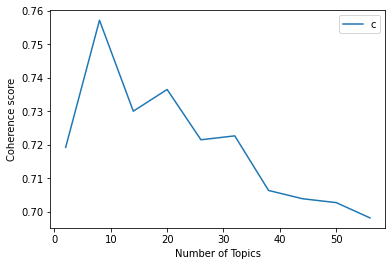

In [63]:
start,stop,step=2,60,6
model_list_lsa, coherence_values_lsa = compute_coherence_values_lsi(id2word, corpus,after_lemmatization,stop, start, step)
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [64]:

for no_of_topics, cv in zip(range(2, 60, 6), coherence_values_lsa):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.534
Num Topics: 8  - Coherence Value: 0.526
Num Topics: 14  - Coherence Value: 0.534
Num Topics: 20  - Coherence Value: 0.529
Num Topics: 26  - Coherence Value: 0.526
Num Topics: 32  - Coherence Value: 0.529
Num Topics: 38  - Coherence Value: 0.5371
Num Topics: 44  - Coherence Value: 0.529
Num Topics: 50  - Coherence Value: 0.534
Num Topics: 56  - Coherence Value: 0.534


In [65]:
#printing topics
pprint(lsamodel.print_topics())

[(0,
  '0.728*"sentiment" + 0.647*"analysis" + 0.077*"use" + 0.070*"survey" + '
  '0.061*"opinion" + 0.057*"technique" + 0.053*"level" + 0.053*"twitter" + '
  '0.052*"mining" + 0.046*"approach"'),
 (1,
  '-0.601*"opinion" + -0.572*"mining" + -0.397*"survey" + 0.205*"use" + '
  '-0.153*"approach" + -0.111*"application" + -0.100*"task" + 0.088*"analysis" '
  '+ 0.087*"technique" + 0.074*"review"'),
 (2,
  '-0.453*"base" + 0.403*"use" + -0.388*"level" + -0.322*"concept" + '
  '-0.237*"approach" + -0.183*"rule" + 0.153*"technique" + 0.134*"learning" + '
  '-0.129*"dependency" + -0.123*"analysis"'),
 (3,
  '0.531*"sentiment" + -0.486*"analysis" + -0.275*"technique" + -0.259*"use" + '
  '-0.193*"review" + -0.145*"comparative" + 0.141*"subjectivity" + '
  '-0.131*"survey" + 0.109*"text" + -0.108*"machine"'),
 (4,
  '0.479*"use" + 0.310*"base" + -0.255*"method" + -0.250*"analysis" + '
  '0.197*"concept" + 0.196*"level" + 0.178*"rule" + 0.172*"opinion" + '
  '0.167*"mining" + -0.147*"combine"')

**Summarization of LSA topics**
1. Survey of techniques of approach for Sentiment Analysis using Twitter.
2. Task, use, applications of Sentiment analysis and opinion mining. 
3. Patterns in sentiment analysis using dependency techniques.
4. Methods of opinion mining based on the concepts of sentiment analysis.
5. Methods of approach to opinion mining and sentiment analysis.
6. Survey on methods and approach towards Sentiment analysis and opinion mining in twitter. 
7. A survey based on approach of concepts using combined texts in sentiment analysis.
8. A survey based on sentiment analysis using Twitter. 
9. Comparision of techniques in applying sentiment anaysis on blogs of the twitter.
10. An overview of current state of developments using sentiment analysis. 
11. Comparision of techniques in applying sentiment anaysis on blogs of the twitter.
12. The review of a publicly available German resource for machine learning in Twitter using sentiment analysis. 
13. The challanges in reviewing the Twitter sentiment analysis of a German resource. 
14. Review of the source of blog using word vectors in sentiment analysis. 
15. Contextual recognition of polarity in Sentiment Analysis. 
16. Challenges of dependencies in polarity of text mining using sentiment analysis. 
17. Challenges of techniques in applying sentiment analysis using the large scale twitter blogs. 
18. Methods of deriving prior polarities from sentiwordNet using sentiment analysis. 
19. A new evaluation of polarities in the field of sentiment analysis. 
20. A publicly available chinese resource on processing of tweets using sentiment analysis. 




## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

Latent Semantic Analysis (LSA) has lower accuracy than Latent Dirichlet allocation (LDA).The Coherence value for optimal number of topics for LSA is 53 where as for LDA is 75. From this we can conclude that Accuracy for LDA is more. If accuracy is more then we can easily generalize model to other new documents. Here, LDA's accuracy is more. LSA has less interpretability among the topics beacuse of dimensionality reduction where as that's not the case in LDA, we interpret topic very easily in LDA. I got 20 topics for LSA and 14 topics for LDA. 14 LDA topics are highly interpretable than 20 topics of LSA. LSA has less efficient representation.